# Full Demo

In [1]:
using AlgebraicRewriting, Catlab, AlgebraicPetri, DataMigrations
using Test

This is a self-contained walkthrough of the main features of AlgebraicRewriting.
This is a regular julia file that can be run interactively.

Importantly:
 - use Julia 1.10
 - activate the environment in AlgebraicRewriting.jl/docs
 - check that graphviz is installed locally (test via "which dot" in terminal)

Table of contents:

1. DPO
2. SPO
3. SqPO
4. PBPO+
5. Generalizing graphs: C-Sets, Slices, etc.
6. Application conditions
7. Attribute variables
8. Graph processes
9. General purpose programming / agent-based modeling
  a. Rewrite and Control Flow boxes
  b. Agents and Query boxes
  c. Data migration
  d. Monadic output

The VS Code REPL makes it easy to have figures automatically pop up in a side
window, so this is the preferred way of interacting with this file. However, if
that is not available, your options are to
1.) copy-paste the code into a Jupyter notebook
2.) use the following `to_svg` function, which will write a graphviz output to
    a SVG file and can be viewed in a browser. The Julia pipe syntax |> allows
    you to easily append " |> to_svg " to a line with a visualization.

In [2]:
to_svg(G, filename="tmp.svg") =
  open(filename, "w") do io
    show(io, "image/svg+xml", G)
  end

to_graphviz(path_graph(Graph, 3))

# 1. DPO

We construct a rule by providing a span, L ← I → R

In [4]:
L = path_graph(Graph, 2)  # • → •
I = Graph(1) # •
R = @acset Graph begin
  V = 1
  E = 1
  src = 1
  tgt = 1
end # •↺
l = ACSetTransformation(I, L; V=[1]) # graph homomorphism data
r = ACSetTransformation(I, R; V=[1])
rule = Rule(l, r)

G = path_graph(Graph, 5)  # • → • → • → • → •
m = only(get_matches(rule, G)) # only one match which satisfies dangling condition

ACSetTransformation((V = FinFunction([4, 5], 2, 5), E = FinFunction([4], 1, 4)), Catlab.Graphs.BasicGraphs.Graph {V:2, E:1}, Catlab.Graphs.BasicGraphs.Graph {V:5, E:4})

Provided a specific match (`m`), we can use the `rule` to rewrite the graph (`G`) using `rewrite_match(rule, m)`.

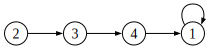

In [5]:
res = rewrite_match(rule, m) # • → • → • → •↺
to_graphviz(res; node_labels=true)

Note that C-Sets are morally regarded up to isomorphism - in particular, limits and colimits may modify the orderings of edges/vertices

In [6]:
expected = @acset Graph begin
  V = 4
  E = 4
  src = [1, 2, 3, 4]
  tgt = [2, 3, 4, 4]
end
@test is_isomorphic(expected, res)

Test Passed

We can also specify the rule via a colimit-of-representables (i.e. generators and relations) syntax. As your schema gets bigger, this becomes more and more convenient. Assigning temporary tags, e.g. `e`, `v`, `eᵣ` to the C-Set elements can also be helpful.

In [7]:
yG = yoneda_cache(Graph, clear=true); # compute representables

rule2 = Rule(@migration(SchRulel, SchGraph, begin
    L => @join begin
      e::E
    end
    K => @join begin
      v::V
    end
    R => @join begin
      eᵣ::E
      src(eᵣ) == tgt(eᵣ)
    end
    l => begin
      v => src(e)
    end
  end), yG)

Rule{:DPO}(ACSetTransformation((V = FinFunction([2], 1, 2), E = FinFunction(Int64[], 0, 1)), Catlab.Graphs.BasicGraphs.Graph {V:1, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:2, E:1}), ACSetTransformation((V = FinFunction([1], 1, 1), E = FinFunction(Int64[], 0, 1)), Catlab.Graphs.BasicGraphs.Graph {V:1, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:1, E:1}), Constraint[], false, Dict{Symbol, Dict{Int64, Union{Nothing, Function}}}())

We can also rewrite without a match (and let it pick an arbitrary match).

In [8]:
@test res == rewrite(rule, G)

Test Passed

# 2. SPO

Rules are by default DPO, but if we specify a type parameter we can change the semantics

In [9]:
rule_spo = Rule{:SPO}(l, r)  # (same data as before)

@test length(get_matches(rule_spo, G)) == 4 # there are now four matches
res = rewrite(rule_spo, G)
to_graphviz(res)
@test is_isomorphic(res, path_graph(Graph, 3) ⊕ R)

Test Passed

**Note**: ⊕ and ⊗ are shorthand for (co)products
_Tip: Julia lets you easily write unicode symbols via "\" followed by a LaTeX name, then hit "Tab" to convert the symbol_

# 3. SqPO

If we duplicate a vertex with an incident edge, it will duplicate the edge

In [10]:
L = Graph(1)
I = Graph(2)
R = path_graph(Graph, 2)

E,src,tgt
1,1,2


We can use automated homomorphism search to reduce the tedium of specifying data manually. In this case, there is a unique option.

In [11]:
l = homomorphism(I, L)

ACSetTransformation((V = FinFunction([1, 1], 2, 1), E = FinFunction(Int64[], 0, 0)), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:1, E:0})

There are many constraints we can put on the search, such as being monic.

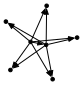

In [12]:
r = homomorphism(I, R; monic=true)

rule_sqpo = Rule{:SqPO}(l, r) # same data as before)


G = star_graph(Graph, 6) # a 5-pointed star
to_graphviz(G; prog="neato") # changing "prog" can sometimes make it look better

m = ACSetTransformation(Graph(1), G; V=[6]) # point at the center
res = rewrite_match(rule_sqpo, m)
to_graphviz(res; prog="neato")

# 4. PBPO+

PBPO+ requires not merely a span but also additional data for L and K which can be thought of as type graphs. The graph G that we rewrite will be typed over the L' type graph to determine how it is rewritten.

In [13]:
L = Graph(1)
K = Graph(2)
l = homomorphism(K, L)
r = id(K)

ACSetTransformation((V = id(FinSet(2)), E = id(FinSet(0))), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:2, E:0})

We allow edges into and out of the matched vertex as well as edges
between the vertices incident to the matched vertex

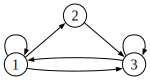

In [14]:
L′ = @acset Graph begin
  V = 3
  E = 6
  src = [1, 1, 1, 2, 3, 3]
  tgt = [1, 2, 3, 3, 3, 1]
end
tl = ACSetTransformation(L, L′; V=[2]) # 2 is the matched vertex
to_graphviz(L′; node_labels=true)

The outneighbors of the matched vertex are duplicated (an edge connects the
old ones to the new ones) and the matched vertex is duplicated. The new copy
of the matched vertex points at the new ones. It does not have any inneighbors.

In [15]:
K′ = @acset Graph begin
  V = 5
  E = 9
  src = [1, 1, 1, 2, 3, 3, 3, 4, 5]
  tgt = [1, 2, 3, 3, 3, 1, 5, 5, 5]
end
tk = ACSetTransformation(K, K′; V=[2, 4])
to_graphviz(K′; node_labels=true)

l′ = homomorphism(K′, L′; initial=(V=[1, 2, 3, 2, 3],))

prule = PBPORule(l, r, tl, tk, l′)

PBPORule(ACSetTransformation((V = FinFunction([1, 1], 2, 1), E = FinFunction(Int64[], 0, 0)), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:1, E:0}), ACSetTransformation((V = id(FinSet(2)), E = id(FinSet(0))), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}), ACSetTransformation((V = FinFunction([2], 1, 3), E = FinFunction(1:0, 0, 6)), Catlab.Graphs.BasicGraphs.Graph {V:1, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:3, E:6}), ACSetTransformation((V = FinFunction([2, 4], 2, 5), E = FinFunction(1:0, 0, 9)), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:5, E:9}), ACSetTransformation((V = FinFunction([1, 2, 3, 2, 3], 5, 3), E = FinFunction([1, 2, 3, 4, 5, 6, 5, 4, 5], 9, 6)), Catlab.Graphs.BasicGraphs.Graph {V:5, E:9}, Catlab.Graphs.BasicGraphs.Graph {V:3, E:6}), false, Constraint[], Constraint[], Dict{Any, Any}(), Dict{Any, Any}(), nothing)

Apply to an example vertex (#3) with two inneighbors and one outneighbor.

In [16]:
G = @acset Graph begin
  V = 4
  E = 5
  src = [1, 1, 2, 3, 4]
  tgt = [2, 3, 3, 4, 4]
end
to_graphviz(G; node_labels=true)

m = get_match(prule, G; initial=(V=[3],) => Dict())

res = rewrite_match(prule, m)

E,src,tgt
1,3,4
2,3,1
3,4,1
4,1,5
5,5,5
6,5,6
7,2,6
8,6,6


V1 is copied to V2. Outneighbor V5 (w/ loop) is copied to V6, creating an edge

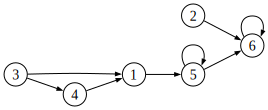

In [17]:
to_graphviz(res; node_labels=true)

# 5. Generalizing Graphs

Any data structure which implements the required functions we need can, in principle, be used for rewriting. Importantly this includes pushout_complement, pushout, and homomorphism search. These are all implemented generically for any C-Set schema (allowing us to rewrite Petri nets, Semisimplicial sets, etc.)

Here we'll do rewriting in graphs sliced over •⇆•, which is isomorphic to the category of (whole-grain) Petri nets, with States and Transitions.

In [18]:
function graph_slice(s::Slice)
  h = s.slice
  V, E = collect.([h[:V], h[:E]])
  g = dom(h)
  (S, T), (I, O) = [[findall(==(i), X) for i in 1:2] for X in [V, E]]
  nS, nT, nI, nO = length.([S, T, I, O])
  findS, findT = [x -> findfirst(==(x), X) for X in [S, T]]
  to_graphviz(@acset AlgebraicPetri.PetriNet begin
    S = nS
    T = nT
    I = nI
    O = nO
    is = findS.(g[I, :src])
    it = findT.(g[I, :tgt])
    ot = findT.(g[O, :src])
    os = findS.(g[O, :tgt])
  end)
end;

This is the graph we are slicing over.

In [19]:
two = @acset Graph begin
  V = 2
  E = 2
  src = [1, 2]
  tgt = [2, 1]
end

E,src,tgt
1,1,2
2,2,1


Define a rule which deletes a [T] -> S edge

In [20]:
L_ = path_graph(Graph, 2)
L = Slice(ACSetTransformation(L_, two, V=[2, 1], E=[2])) # [T] ⟶ (S)
graph_slice(L)

I_ = Graph(1)
I = Slice(ACSetTransformation(I_, two, V=[2])) # [T]
R_ = Graph(2)
R = Slice(ACSetTransformation(R_, two, V=[2, 1])) # [T]  (S)

Catlab.CategoricalAlgebra.Slices.Slice{Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, @NamedTuple{V::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, E::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, UnitRange{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}, Catlab.Graphs.BasicGraphs.Graph, Catlab.Graphs.BasicGraphs.Graph}}(ACSetTransformation((V = FinFunction([2, 1], 2, 2), E = FinFunction(1:0, 0, 2)), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:2, E:2}))

Using homomorphism search in the slice category

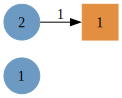

In [21]:
rule = Rule(homomorphism(I, L), homomorphism(I, R))

G_ = path_graph(Graph, 3)
G = Slice(ACSetTransformation(G_, two, V=[1, 2, 1], E=[1, 2])) # (S) ⟶ [T] ⟶ (S)
graph_slice(G)

res = rewrite(rule, G) # (S) ⟶ [T]  (S)
graph_slice(res)

While the vast majority of functionality is focused on ACSets at the present moment, but there is nothing in principle which limits this.

# 6. Application conditions

We can construct commutative diagrams with certain edges left unspecified or marked with ∀ or ∃. If only one edge is left free, we can treat the diagram as a boolean function which tests whether the morphism makes the specified paths commute (or not commute). This generalizes positive/negative application conditions and lifting conditions, but because those are most common there are constructors AppCond and LiftCond to make these directly.

         ∀
  [↻•]   →  ?
    ↓    ↗ ∃ ↓
  [↻•⟶•]  → [↻•⟶•⟵•↺]

Every vertex with a loop also has a map to the vertex marked by the bottom map.

In [22]:
t = terminal(Graph) |> apex
looparr = @acset_colim yG begin
  (e1, e2)::E
  src(e1) == tgt(e1)
  src(e1) == src(e2)
end

v = homomorphism(t, looparr)
loop_csp = @acset Graph begin
  V = 3
  E = 4
  src = [1, 3, 1, 3]
  tgt = [1, 3, 2, 2]
end
b = homomorphism(looparr, loop_csp; monic=true)
constr = LiftCond(v, b)

@test !apply_constraint(constr, homomorphism(t, loop_csp))
@test apply_constraint(constr, b)

Test Passed

We can combining constraints with logical combinators.

match vertex iff it has 2 or 3 self loops

In [23]:
one, two, three, four, five = [@acset(Graph, begin
  V = 1
  E = n
  src = 1
  tgt = 1
end) for n in 1:5]

c2 = AppCond(homomorphism(Graph(1), two); monic=true)         # PAC
c3 = AppCond(homomorphism(Graph(1), four), false; monic=true) # NAC
constr = c2 ⊗ c3 # logical conjunction: 2 ≤ |E| < 4

rule = Rule(id(Graph(1)), id(Graph(1)); ac=[constr])

G = two ⊕ three ⊕ two ⊕ four ⊕ five ⊕ one

@test length(get_matches(rule, G)) == 3

Test Passed

# 7. Attribute variables

Normally ACSet morphisms must match attribute values exactly, i.e. a weighted
graph edge of 8.3 can only be mapped to another edge weighted at 8.3. This
becomes very restricted, especially when we want to do some simple computations
with attribute values (e.g. when merging two edges, add their values together)

A recent extension of ACSets makes this possible - each attribute type comes
equipped with a finite set of "variables" which can be mapped to any concrete
value (or another variable).

In [24]:
yWG = yoneda_cache(WeightedGraph{Int}; clear=true);
L = @acset_colim yWG begin
  (e1, e2)::E
  src(e1) == src(e2)
  tgt(e1) == tgt(e2)
end
I = WeightedGraph{Int}(2)
R = @acset WeightedGraph{Int} begin
  V = 2
  E = 1
  Weight = 1
  src = 1
  tgt = 2
  weight = [AttrVar(1)]
end

l = homomorphism(I, L; monic=true)
r = homomorphism(I, R; monic=true)
rule = Rule(l, r; monic=[:E], expr=Dict(:Weight => [xs -> xs[1] + xs[2]]))

G = @acset WeightedGraph{Int} begin
  V = 1
  E = 3
  src = 1
  tgt = 1
  weight = [10, 20, 100]
end

@test rewrite(rule, G) == @acset WeightedGraph{Int} begin
  V = 1
  E = 2
  src = 1
  tgt = 1
  weight = [30, 100]
end

Test Passed

# 8. Graph processes

A sequence of rewrite applications can be given a poset structure where α ≤ β
means that the rule application α needed to occur before β.  This is computed
via analyzing the colimit of all the partial maps induced by the rewrites.

In [25]:
using AlgebraicRewriting.Processes: RWStep, find_deps

G0, G1, G2, G3 = Graph.([0, 1, 2, 3])

4-element Vector{Catlab.Graphs.BasicGraphs.Graph}:
 Catlab.Graphs.BasicGraphs.Graph:
  V = 1:0
  E = 1:0
  src : E → V = Int64[]
  tgt : E → V = Int64[]
 Catlab.Graphs.BasicGraphs.Graph:
  V = 1:1
  E = 1:0
  src : E → V = Int64[]
  tgt : E → V = Int64[]
 Catlab.Graphs.BasicGraphs.Graph:
  V = 1:2
  E = 1:0
  src : E → V = Int64[]
  tgt : E → V = Int64[]
 Catlab.Graphs.BasicGraphs.Graph:
  V = 1:3
  E = 1:0
  src : E → V = Int64[]
  tgt : E → V = Int64[]

Delete a node

In [26]:
Rule1 = Span(create(G1), id(G0));

Merge two nodes

In [27]:
Rule2 = Span(id(G2), homomorphism(G2, G1));

Add a node

In [28]:
Rule3 = Span(id(G0), create(G1))

R1, R2, R3 = [Rule(l, r) for (l, r) in [Rule1, Rule2, Rule3]]

3-element Vector{Rule{:DPO}}:
 Rule{:DPO}(ACSetTransformation((V = FinFunction(Int64[], 0, 1), E = FinFunction(Int64[], 0, 0)), Catlab.Graphs.BasicGraphs.Graph {V:0, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:1, E:0}), ACSetTransformation((V = id(FinSet(0)), E = id(FinSet(0))), Catlab.Graphs.BasicGraphs.Graph {V:0, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:0, E:0}), Constraint[], false, Dict{Symbol, Dict{Int64, Union{Nothing, Function}}}())
 Rule{:DPO}(ACSetTransformation((V = id(FinSet(2)), E = id(FinSet(0))), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}), ACSetTransformation((V = FinFunction([1, 1], 2, 1), E = FinFunction(Int64[], 0, 0)), Catlab.Graphs.BasicGraphs.Graph {V:2, E:0}, Catlab.Graphs.BasicGraphs.Graph {V:1, E:0}), Constraint[], false, Dict{Symbol, Dict{Int64, Union{Nothing, Function}}}())
 Rule{:DPO}(ACSetTransformation((V = id(FinSet(0)), E = id(FinSet(0))), Catlab.Graphs.BasicGraphs.Graph {V:0, E:0}, Catlab.Graphs.BasicGraphs.Graph

# 9. Trajectory

Step 1: add node 3 to G2

In [29]:
M1 = create(G2)
CM1 = ACSetTransformation(G1, G3; V=[3])
Pmap1 = Span(id(G2), ACSetTransformation(G2, G3; V=[1, 2]))
RS1 = RWStep(Rule3, Pmap1, M1, CM1)

AlgebraicRewriting.Processes.RWStep(Catlab.CategoricalAlgebra.FreeDiagrams.Multispan{Catlab.Graphs.BasicGraphs.Graph, Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, Comp, Catlab.Graphs.BasicGraphs.Graph, Catlab.Graphs.BasicGraphs.Graph} where Comp<:NamedTuple, StaticArraysCore.SVector{2, Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, Comp, Catlab.Graphs.BasicGraphs.Graph, Catlab.Graphs.BasicGraphs.Graph} where Comp<:NamedTuple}}(Catlab.Graphs.BasicGraphs.Graph:
  V = 1:0
  E = 1:0
  src : E → V = Int64[]
  tgt : E → V = Int64[], Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, Comp, Catlab.Graphs

Step 2: merge node 2 and 3 to yield a G2

In [30]:
M2 = ACSetTransformation(G2, G3; V=[2, 3])
CM2 = ACSetTransformation(G1, G2; V=[2])
Pmap2 = Span(id(G3), ACSetTransformation(G3, G2; V=[1, 2, 2]))
RS2 = RWStep(Rule2, Pmap2, M2, CM2)

AlgebraicRewriting.Processes.RWStep(Catlab.CategoricalAlgebra.FreeDiagrams.Multispan{Catlab.Graphs.BasicGraphs.Graph, Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, Comp, Catlab.Graphs.BasicGraphs.Graph, Catlab.Graphs.BasicGraphs.Graph} where Comp<:NamedTuple, StaticArraysCore.SVector{2, Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, Comp, Catlab.Graphs.BasicGraphs.Graph, Catlab.Graphs.BasicGraphs.Graph} where Comp<:NamedTuple}}(Catlab.Graphs.BasicGraphs.Graph:
  V = 1:2
  E = 1:0
  src : E → V = Int64[]
  tgt : E → V = Int64[], Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:V, :E}, Tuple{(:src, :E, :V), (:tgt, :E, :V)}, Tuple{}, Tuple{}}, Comp, Catlab.Graphs

Step 3: delete vertex 1

In [31]:
M3 = ACSetTransformation(G1, G2; V=[1])
CM3 = create(G1)
Pmap3 = Span(ACSetTransformation(G1, G2; V=[2]), id(G1))
RS3 = RWStep(Rule1, Pmap3, M3, CM3)


steps = [RS1, RS2, RS3]

g = find_deps(steps)
to_graphviz(g; node_labels=true)

expected = @acset Graph begin
  V = 3
  E = 1
  src = 1
  tgt = 2
end
@test expected == g

Test Passed

Interface that just uses rules and match morphisms:
The matches needed to be updated to reflect the particular isomorph that DPO
rewriting produces when applying the rule.

In [32]:
σ₂ = ACSetTransformation(G2, G2; V=[2, 1])
σ₃ = ACSetTransformation(G3, G3; V=[3, 1, 2])

g′ = find_deps([R3 => M1, R2 => M2 ⋅ σ₃, R1 => M3 ⋅ σ₂])
@test g′ == g

Test Passed